This Compares all the models

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score, recall_score, 
                             f1_score, log_loss, brier_score_loss, roc_auc_score, roc_curve, 
                             precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay)

import torch
import torch.nn as nn
import torch.optim as optim

from xgboost import XGBClassifier

In [ ]:
#Define a list where we will keep all of the data
model_performances = []

#Define the df
df = pd.read_csv("data\\Traffic.csv")

This section will hadel the NN

In [ ]:
"""
Prepare the data for the NN
"""
X = df.drop(columns="Traffic Situation")
y = df["Traffic Situation"]

X["day_of_the_month_sin"] = np.sin(2 * np.pi * X["Date"] / 31)
X["day_of_the_month_cos"] = np.cos(2 * np.pi * X["Date"] / 31)
X = X.drop(columns="Date")

day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

X['Day of the week'] = X['Day of the week'].map(day_mapping)

X["hour"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.hour  
X["minute"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.minute  
X["Time"] = X["hour"] * 60 + X["minute"]

X["Time_sin"] = np.sin(2 * np.pi * X["Time"] / 1425)
X["Time_cos"] = np.cos(2 * np.pi * X["Time"] / 1425)
X = X.drop(columns=['hour', 'minute', 'Time'])

target_mapping = {
    'heavy': 0,
    'high' : 1,
    'normal' : 2,
    'low' : 3
}

y = y.map(target_mapping)

scaler = MinMaxScaler()

columns_to_normalize = ['Day of the week', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 
                        'day_of_the_month_sin', 'day_of_the_month_cos', 'Time_sin', 'Time_cos']

X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])

X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, train_size=0.2, random_state=42)

In [7]:
class TrafficNN(nn.Module):
    def __init__(self):
        super(TrafficNN, self).__init__()
        self.layer1 = nn.Linear(10,20)
        self.layer2 = nn.Linear(20,10)
        self.layer3 = nn.Linear(10,4)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

In [8]:
model = TrafficNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

#TODO, put in the optimal nn parameters once you find them

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train) 
    loss = criterion(outputs, y_train) 
    loss.backward() 
    optimizer.step() 

In [9]:
model.eval()

with torch.no_grad():
    outputs = model(X_test)  # Forward pass
    y_pred = torch.argmax(outputs, dim=1)

y_pred = y_pred.numpy()

accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

model_performances.append(["NN", accuracy, balanced_acc, precision, recall, f1])

print(f"Finished: NN") 

Finished: NN


This section will handel the Pipelines

In [12]:
"""
This cell gets the data ready to get passed into a pipeline
"""
X = df.drop(columns="Traffic Situation")
y = df["Traffic Situation"]

day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

X['Day of the week'] = X['Day of the week'].map(day_mapping)

X["hour"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.hour  
X["minute"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.minute  
X["Time"] = X["hour"] * 60 + X["minute"]
X = X.drop(columns=['hour', 'minute'])

target_mapping = {
    'heavy': 0,
    'high' : 1,
    'normal' : 2,
    'low' : 3
}

y = y.map(target_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [13]:
numeric_features = ['Date', 'Time', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
categorical_features = ['Day of the week']

numerical_pipeline = Pipeline([
    ("scalar", StandardScaler()) #We're gonna normalize the numeric data 
])

categorical_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore")) #Shouldn't have to worry about unknowns 
])

preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

In [14]:
SVC_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("svc", SVC(
        C = 100, 
        gamma = 'auto', 
        kernel = 'rbf'
    ))
])

GBC_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('gbc', GradientBoostingClassifier(
        learning_rate = 0.1, 
        max_depth = 3, 
        max_features = 'log2', 
        n_estimators = 500, 
        subsample = 1.0
    ))
])

LogReg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('logreg', LogisticRegression(
        C = 100, 
        solver = 'lbfgs'
    ))
])

RFC_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        max_depth = 10, 
        max_features = 'sqrt', 
        min_samples_leaf = 2, 
        min_samples_split = 2, 
        n_estimators = 100,
        random_state = 42
    ))
])

XGB_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=3, 
        eval_metric="logloss", 
        random_state=42,
    ))
])

In [15]:
model_names = ["SVC", "GBC", "Log", "RFC", "XGB"]
models = [SVC_pipeline, GBC_pipeline, LogReg_pipeline, RFC_pipeline, XGB_pipeline]

for name, model in zip(model_names, models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    model_performances.append([name, accuracy, balanced_acc, precision, recall, f1])

    print(f"Finished: {name}")   

Finished: SVC
Finished: GBC
Finished: Log
Finished: RFC
Finished: XGB


This section will hand Statsmodels

This is where the visualization of all the data will be visualized

NN: 0.9026
SVC: 0.8950
GBC: 0.9941
Log: 0.8925
RFC: 0.9744
XGB: 0.9966


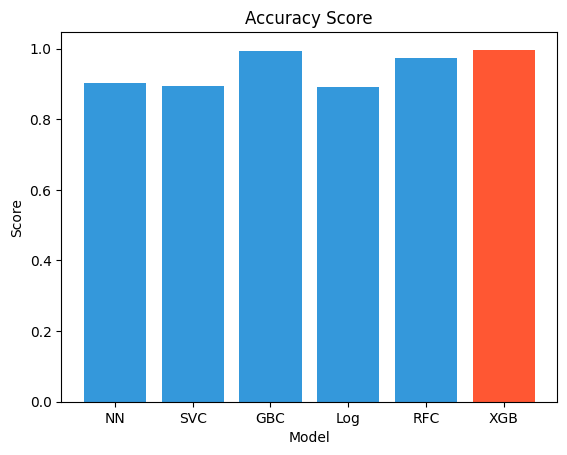

In [ ]:
models = [name[0] for name in model_performances]
scores = [score[1] for score in model_performances]

colors = ["#3498DB"] * len(models)

colors[np.argmax(scores)] = "#FF5733"


plt.bar(models, scores, color=colors)
plt.title("Accuracy Score")
plt.ylabel("Score")
plt.xlabel("Model")

print("Accuracy Scores")
for name, score in zip(models, scores):
    print(f"{name}: {score:.4f}")

plt.show()


Balanced Accuracy Scores
NN: 0.8512
SVC: 0.8667
GBC: 0.9937
Log: 0.8464
RFC: 0.9526
XGB: 0.9985


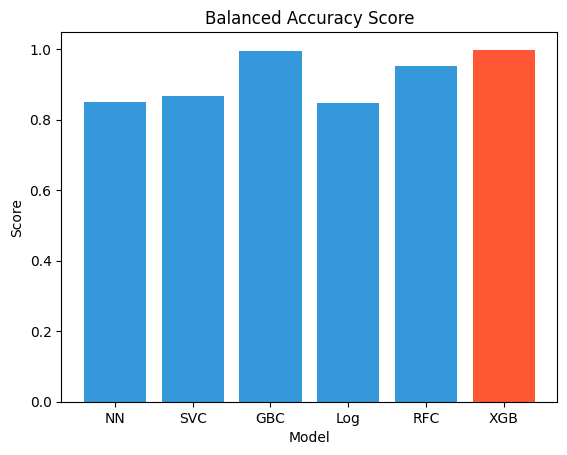

In [41]:
models = [name[0] for name in model_performances]
scores = [score[2] for score in model_performances]

colors = ["#3498DB"] * len(models)

colors[np.argmax(scores)] = "#FF5733"


plt.bar(models, scores, color=colors)
plt.title("Balanced Accuracy Score")
plt.ylabel("Score")
plt.xlabel("Model")

print("Balanced Accuracy Scores")
for name, score in zip(models, scores):
    print(f"{name}: {score:.4f}")

plt.show()


Precision
NN: 0.9018
SVC: 0.8966
GBC: 0.9941
Log: 0.8913
RFC: 0.9747
XGB: 0.9967


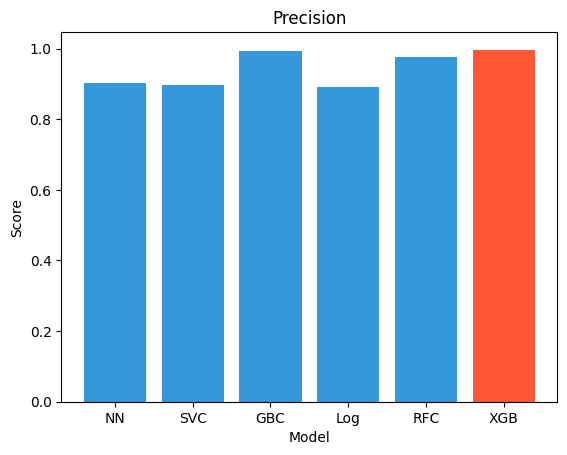

In [45]:
models = [name[0] for name in model_performances]
scores = [score[3] for score in model_performances]

colors = ["#3498DB"] * len(models)

colors[np.argmax(scores)] = "#FF5733"


plt.bar(models, scores, color=colors)
plt.title("Precision")
plt.ylabel("Score")
plt.xlabel("Model")

print("Precision")
for name, score in zip(models, scores):
    print(f"{name}: {score:.4f}")

plt.show()


Recall
NN: 0.9026
SVC: 0.8950
GBC: 0.9941
Log: 0.8925
RFC: 0.9744
XGB: 0.9966


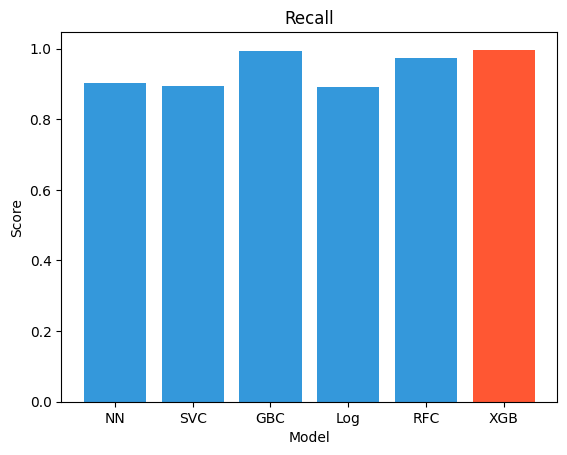

In [44]:
models = [name[0] for name in model_performances]
scores = [score[4] for score in model_performances]

colors = ["#3498DB"] * len(models)

colors[np.argmax(scores)] = "#FF5733"


plt.bar(models, scores, color=colors)
plt.title("Recall")
plt.ylabel("Score")
plt.xlabel("Model")

print("Recall")
for name, score in zip(models, scores):
    print(f"{name}: {score:.4f}")

plt.show()


F1
NN: 0.8997
SVC: 0.8942
GBC: 0.9941
Log: 0.8911
RFC: 0.9736
XGB: 0.9966


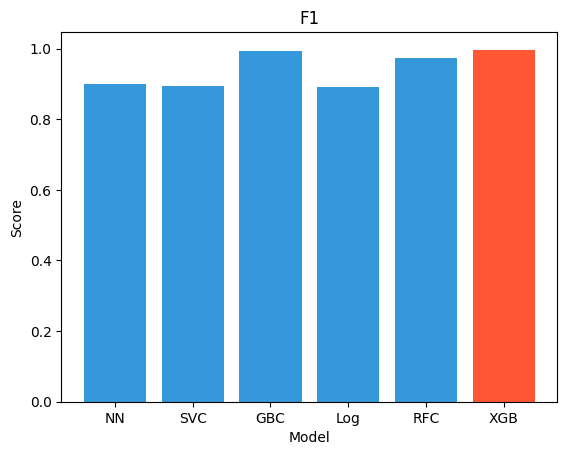

In [43]:
models = [name[0] for name in model_performances]
scores = [score[5] for score in model_performances]

colors = ["#3498DB"] * len(models)

colors[np.argmax(scores)] = "#FF5733"


plt.bar(models, scores, color=colors)
plt.title("F1")
plt.ylabel("Score")
plt.xlabel("Model")

print("F1")
for name, score in zip(models, scores):
    print(f"{name}: {score:.4f}")

plt.show()
